In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchmetrics.classification import Dice
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import random
import torch
from utils import unet, mypreprocess, util_functions
from tqdm import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
import json
import warnings
warnings.filterwarnings("ignore")
import math
import gc

In [2]:
base_path = '/scratch/student/sinaziaee/datasets/2d_dataset'
train_dir = os.path.join(base_path, 'training')
valid_dir = os.path.join(base_path, 'validation')
img_size = 512
train_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(2*math.pi),
        transforms.RandomResizedCrop(img_size, scale=(0.7, 1.4)),
        transforms.GaussianBlur(1),
        transforms.ColorJitter(brightness=(0.75, 1.25), contrast=(0.5, 2)),
        transforms.Lambda(lambda img: util_functions.apply_gaussian_noise(img, std_dev=0.1) if torch.rand(1) < 0.1 else img),
    ])
valid_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size), antialias=True),
    ])
batch_size = 64

plain_train_loader = mypreprocess.create_data_loaders(path_dir=train_dir, image_dir='images', 
                                            label_dir='labels', data_transformer=valid_transformer, batch_size=batch_size, split_size=None)
augmented_train_loader = mypreprocess.create_data_loaders(path_dir=train_dir, image_dir='images', 
                                            label_dir='labels', data_transformer=train_transformer, batch_size=batch_size, split_size=None)
train_loader = DataLoader(ConcatDataset([plain_train_loader.dataset, augmented_train_loader.dataset]), batch_size=batch_size, shuffle=True)
valid_loader = mypreprocess.create_data_loaders(path_dir=valid_dir, image_dir='images', 
                                            label_dir='labels', data_transformer=valid_transformer, batch_size=batch_size, split_size=None)

# train_loader = valid_loader

del plain_train_loader
del augmented_train_loader

# Run garbage collection to free up memory
gc.collect()
print("Size of the training dataset:", len(train_loader.dataset))

dataset info: 
 No images: 15033, No masks: 15033, 
 No of batches: 235, batch shape: torch.Size([64, 1, 512, 512])
dataset info: 
 No images: 15033, No masks: 15033, 
 No of batches: 235, batch shape: torch.Size([64, 1, 512, 512])
dataset info: 
 No images: 737, No masks: 737, 
 No of batches: 12, batch shape: torch.Size([64, 1, 512, 512])
Size of the training dataset: 30066


torch.Size([64, 1, 512, 512])
Len of train_loader: 470


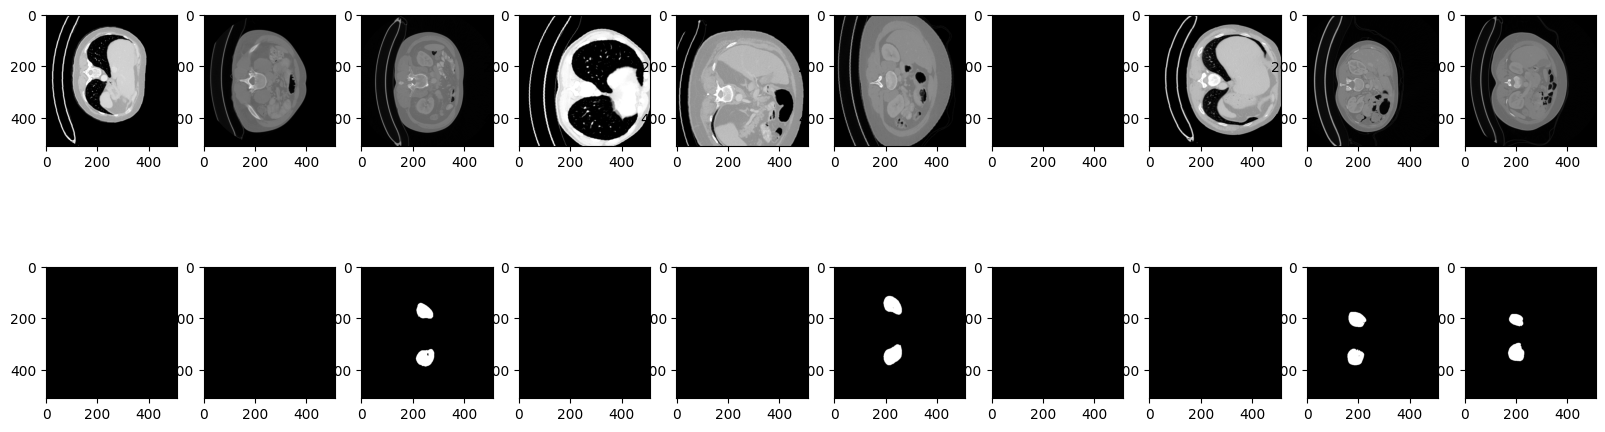

In [3]:
util_functions.visualize_dataset(train_loader)

# DataSet size
original number of 2d images for training: 15033, validation: 733

after augmentation the number of training images are 30066, validation 733

In [4]:
def train_fn(data_loader, model, criterion, optimizer, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.train()
    total_loss = 0
    for batch in data_loader:
        if is_parallel is False:
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)
        else:
            images, masks = batch[0].to(device_0), batch[1].to(device_1)
        
        outputs = model(images)
        
        optimizer.zero_grad() 
        # print(outputs.shape) 
        # print(masks.shape)
        loss1 = criterion(outputs, masks)
        if criterion2 is not None:
            loss2 = criterion2(outputs, masks)
            loss = loss1 + loss2
        else:
            loss = loss1
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [5]:
def eval_fn(data_loader, model, criterion, device, criterion2=None, is_parallel=False, device_0=None, device_1=None):
    model.eval()
    total_loss = 0
    total_iou = 0
    with torch.no_grad():
        for batch in data_loader:
            if is_parallel is False:
                images, masks = batch
                images = images.to(device)
                masks = masks.to(device)
            else:
                images, masks = batch[0].to(device_0), batch[1].to(device_1)
            
            outputs = model(images)
            if criterion2 == None:
                loss = criterion(outputs, masks)
            else:
                loss = criterion(outputs, masks) + criterion2(outputs, masks)
            total_loss += loss.item()
            iou = util_functions.calculate_IoU(outputs, masks)
            total_iou += iou.item()
            # dice_value = dice_coefficient2(masks, outputs)
            dice_metric = Dice()
            # dice_value = dice_metric(outputs.to(torch.float32), masks.to(torch.int32)).item()
            dice_value = 0
        
        avg_loss = total_loss / len(data_loader)
        avg_iou = total_iou / len(data_loader)
    return avg_loss, avg_iou, dice_value

In [6]:
def train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device,
                                criterion1, criterion2 = None, device_0 = None, device_1 = None, is_parallel=True):
    if is_parallel is False:
        model = model.to(device)
    else:
        model = nn.DataParallel(model, device_ids=[0, 1])
        
    best_valid_loss = np.Inf

    train_loss_list = []
    valid_loss_list = []
    valid_iou_list = []
    valid_dice_list = []

    results_folder = util_functions.create_result_folder(path='results')
    print(results_folder)
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_fn(data_loader=train_loader, model=model, criterion=criterion1, 
                              optimizer=optimizer, device=device, criterion2=criterion2,
                              is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        valid_loss, valid_iou, valid_dice = eval_fn(data_loader=valid_loader, model=model, criterion=criterion1,
                                        device=device, criterion2=criterion2,
                                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        valid_iou_list.append(valid_iou)
        valid_dice_list.append(valid_dice)
        
        if best_valid_loss > valid_loss:
            best_valid_loss = valid_loss
            directory = 'results'
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save(model.state_dict(), f'{results_folder}/best_model.pt')
            print('SAVED-MODEL')
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')
            util_functions.visualize_training(train_loss_list=train_loss_list, valid_loss_list=valid_loss_list,
                                            valid_iou_list=valid_iou_list, valid_dice_list=valid_dice_list, results_folder=results_folder)
            
        lists_dict = {
            'train_loss_list': train_loss_list,
            'valid_loss_list': valid_loss_list,
            'valid_iou_list': valid_iou_list,
            'valid_dice_list': valid_dice_list,
        }

        with open(f'{results_folder}/training_trend.json', 'w') as f:
            json.dump(lists_dict, f)
                

In [7]:
is_parallel = False
# Parallel training
model = unet.UNet(num_classes=1, input_channels=1)
# model = smp.Unet(classes=1, in_channels=1)
# model.load_state_dict(torch.load('results/best_model.pt'))
device = torch.device('cuda:0')
device_0 = torch.device('cuda:0')
device_1 = torch.device('cuda:1')
if is_parallel is True:
    model.to(device_0)
    model.to(device_1)
    model = nn.DataParallel(model, device_ids=[0, 1])
else:
    model.to(device)
print(device)

cuda:0


results/2023-11-09_23-27


  0%|          | 0/71 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 0.9358540428445694, Valid Loss: 0.9038730909427007


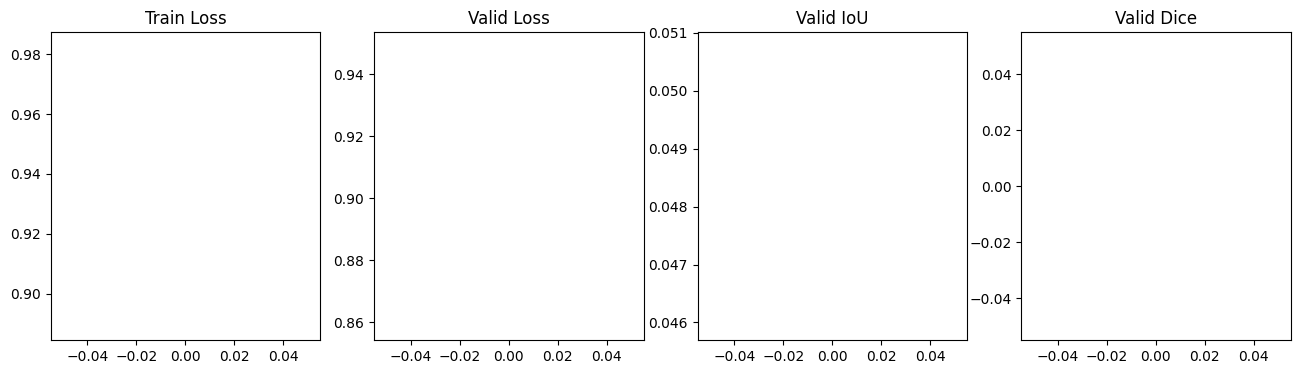

  3%|▎         | 2/71 [15:06<8:41:18, 453.31s/it]

SAVED-MODEL


  6%|▌         | 4/71 [30:14<8:26:55, 453.97s/it]

SAVED-MODEL


  7%|▋         | 5/71 [37:45<8:18:17, 452.99s/it]

SAVED-MODEL


  8%|▊         | 6/71 [45:18<8:10:38, 452.91s/it]

SAVED-MODEL


 11%|█▏        | 8/71 [1:00:22<7:55:10, 452.54s/it]

SAVED-MODEL


 13%|█▎        | 9/71 [1:07:56<7:48:06, 453.00s/it]

SAVED-MODEL


 14%|█▍        | 10/71 [1:15:31<7:41:00, 453.45s/it]

SAVED-MODEL
SAVED-MODEL
Epoch: 11, Train Loss: 0.7567875290170629, Valid Loss: 0.49194542070229846


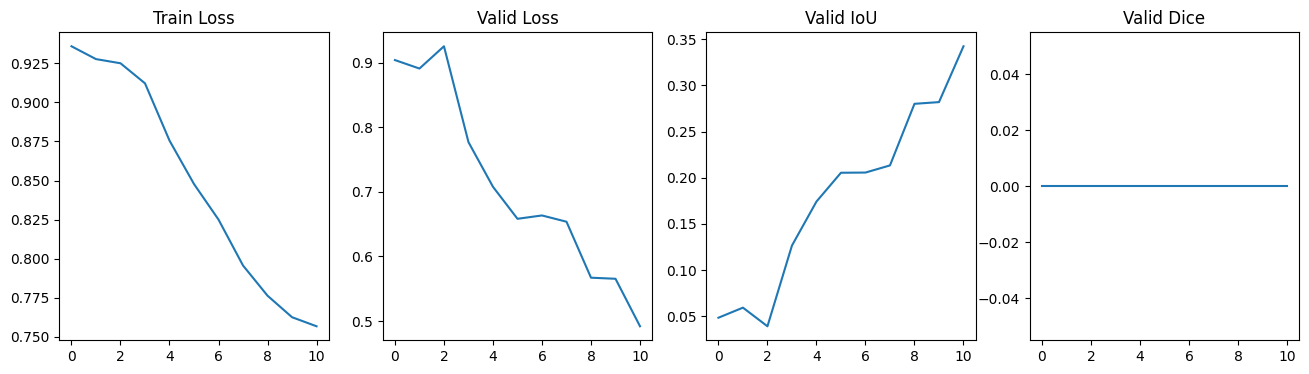

 21%|██        | 15/71 [1:53:19<7:03:05, 453.31s/it]

SAVED-MODEL


 23%|██▎       | 16/71 [2:00:51<6:55:14, 452.98s/it]

SAVED-MODEL


 28%|██▊       | 20/71 [2:31:00<6:24:22, 452.21s/it]

Epoch: 21, Train Loss: 0.6983199005431318, Valid Loss: 0.5283697148164114


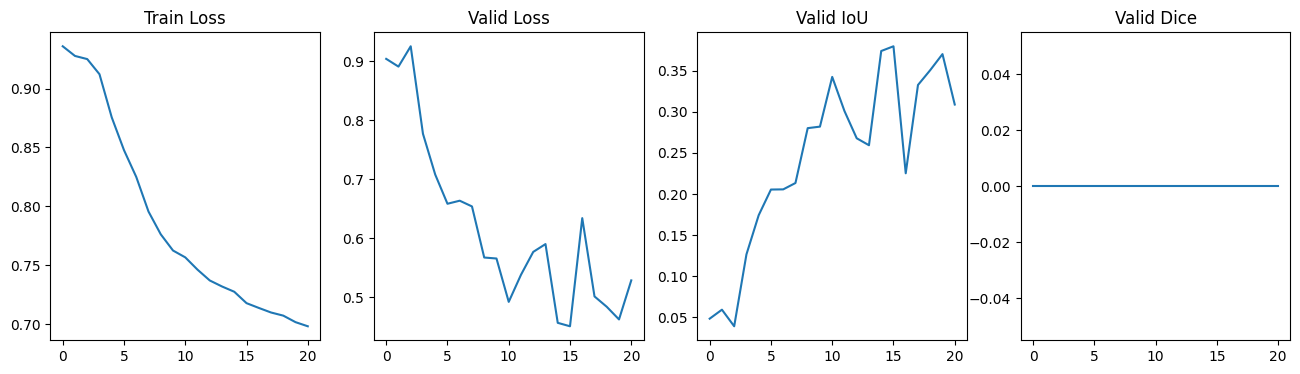

 37%|███▋      | 26/71 [3:16:20<5:39:48, 453.07s/it]

SAVED-MODEL


 38%|███▊      | 27/71 [3:23:54<5:32:27, 453.34s/it]

SAVED-MODEL


 41%|████      | 29/71 [3:39:00<5:17:11, 453.13s/it]

SAVED-MODEL


 42%|████▏     | 30/71 [3:46:32<5:09:25, 452.81s/it]

Epoch: 31, Train Loss: 0.6771757201945529, Valid Loss: 0.4042998303969701


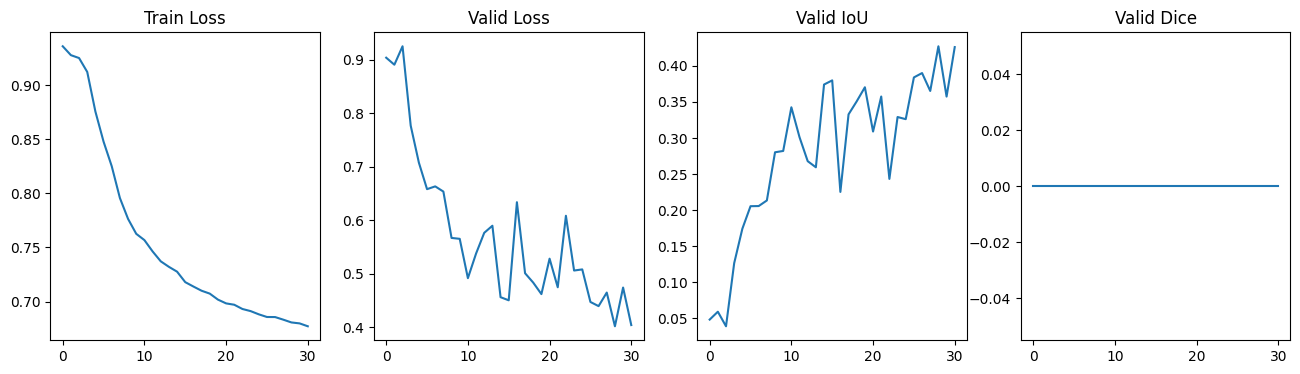

 54%|█████▎    | 38/71 [4:46:50<4:08:52, 452.50s/it]

SAVED-MODEL


 56%|█████▋    | 40/71 [5:01:55<3:53:47, 452.51s/it]

SAVED-MODEL
Epoch: 41, Train Loss: 0.6670422502020572, Valid Loss: 0.4200758437315623


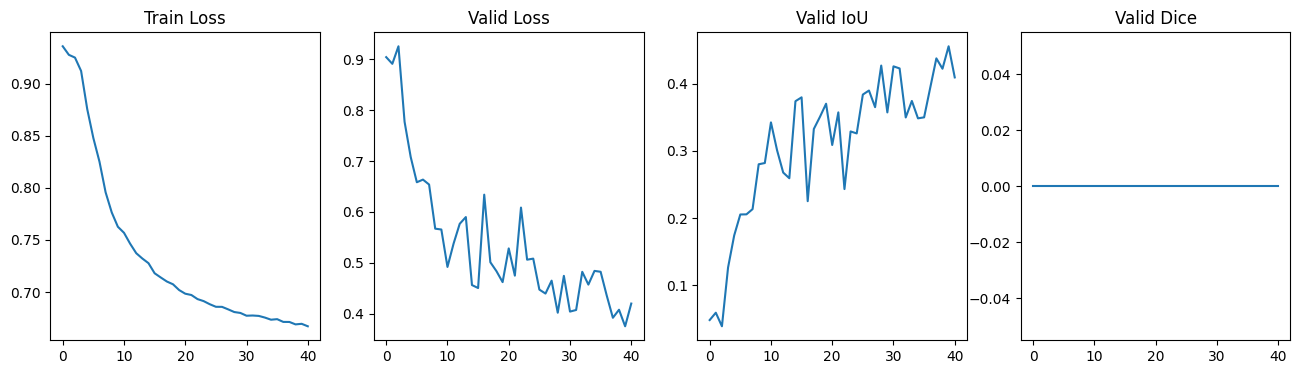

 70%|███████   | 50/71 [6:17:22<2:38:21, 452.44s/it]

Epoch: 51, Train Loss: 0.6611715850677896, Valid Loss: 0.406183918317159


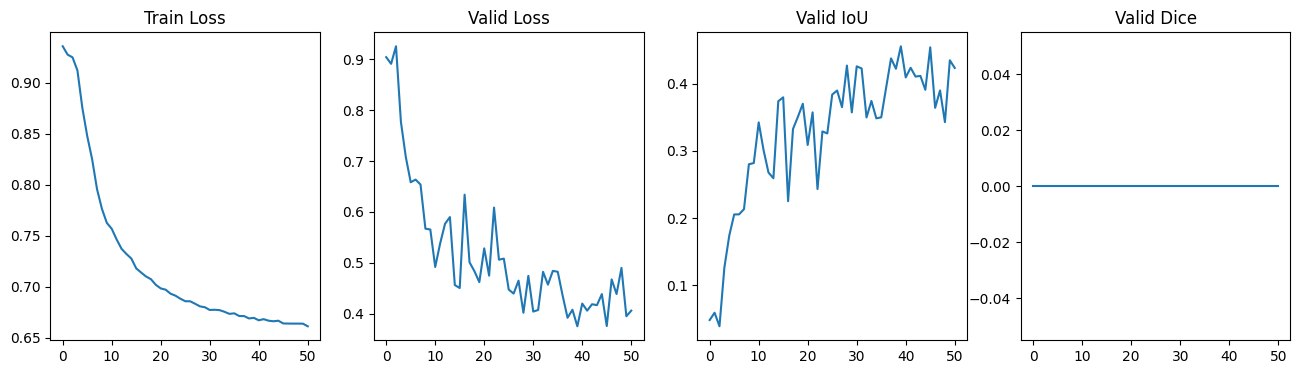

 80%|████████  | 57/71 [7:10:16<1:45:39, 452.82s/it]

SAVED-MODEL


 85%|████████▍ | 60/71 [7:32:58<1:23:10, 453.69s/it]

Epoch: 61, Train Loss: 0.6565625594017354, Valid Loss: 0.4667457789182663


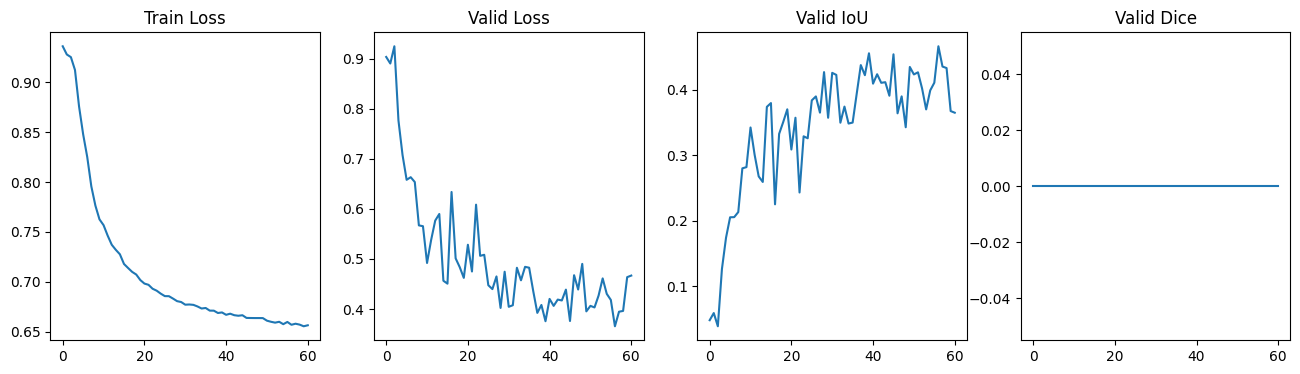

 99%|█████████▊| 70/71 [8:46:19<07:14, 434.92s/it]  

Epoch: 71, Train Loss: 0.6526918737178153, Valid Loss: 0.4034543385108312


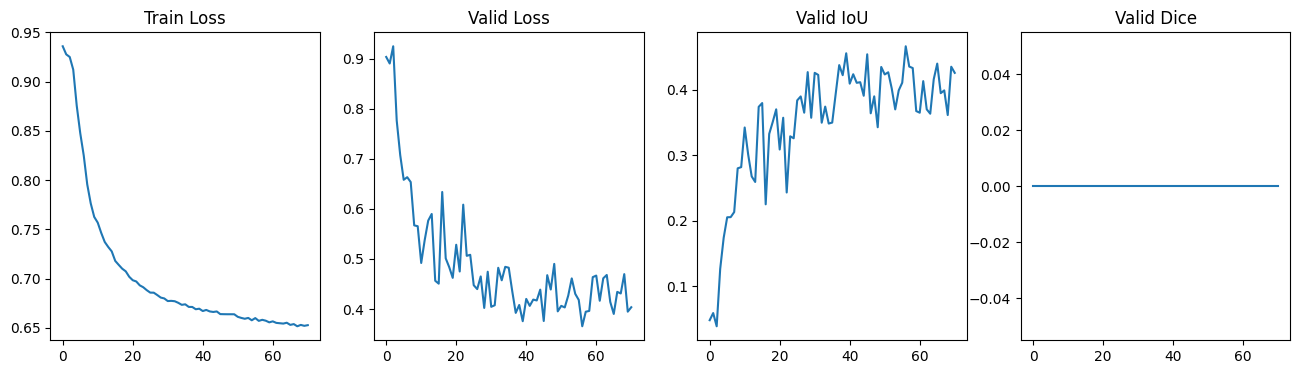

100%|██████████| 71/71 [8:53:34<00:00, 450.90s/it]


In [8]:
criterion1 = DiceLoss(mode="binary")
criterion2 = nn.BCEWithLogitsLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 71

train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, None,
                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)

In [11]:
torch.cuda.empty_cache()

In [10]:
model = unet.UNet(num_classes=1, input_channels=1)
# model = smp.Unet(classes=1, in_channels=1)
model.load_state_dict(torch.load('results/best_model.pt'))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:0')
device_0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_1 = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
if is_parallel is True:
    model.to(device_0)
    model.to(device_1)
    model = nn.DataParallel(model, device_ids=[0, 1])
else:
    model.to(device)
print(device)

cuda:0


In [ ]:
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, None,
                        is_parallel=is_parallel, device_0=device_0, device_1=device_1)

In [14]:
idx = 10
model.load_state_dict(torch.load('results/best_model.pt'))
data_iter = iter(valid_loader)
images, masks = next(data_iter)
image = images[idx]
mask = masks[idx]
logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

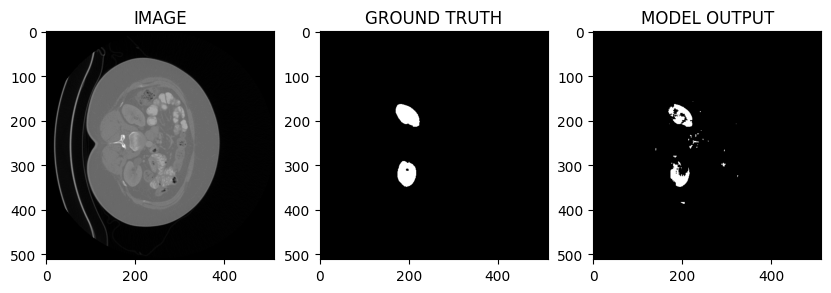

In [15]:
util_functions.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

In [15]:
model = unet.UNet(input_channels=1, num_classes=1)
model.load_state_dict(torch.load('results/best_model.pt'))
model = model.to(device)

  0%|          | 0/500 [00:00<?, ?it/s]

SAVED-MODEL
Epoch: 1, Train Loss: 0.7166332229971886, Valid Loss: 0.33545786142349243


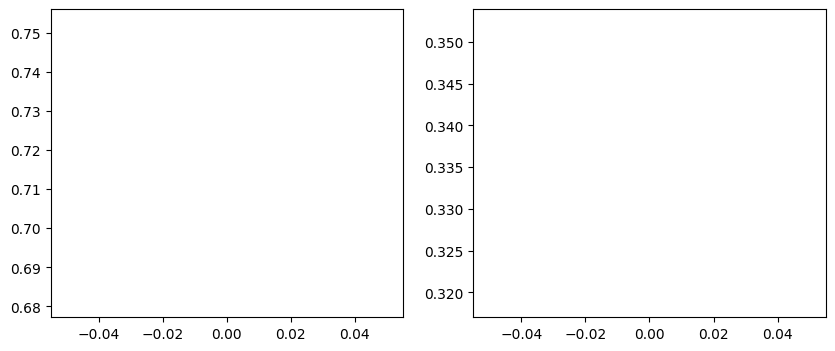

 10%|█         | 50/500 [47:29<7:08:19, 57.11s/it]

Epoch: 51, Train Loss: 0.7128799110651016, Valid Loss: 0.33545786142349243


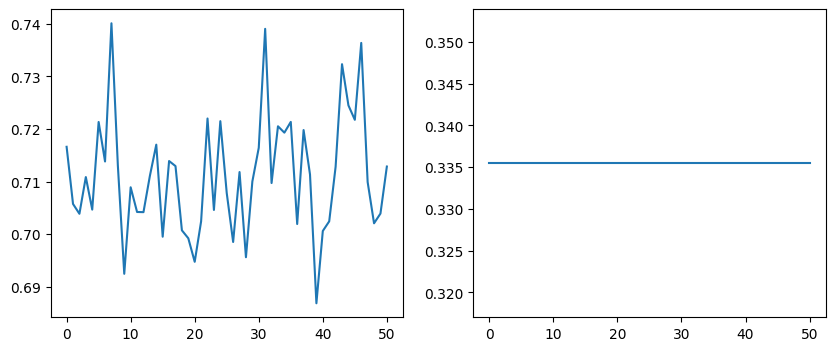

 20%|██        | 100/500 [1:34:22<6:43:47, 60.57s/it]

Epoch: 101, Train Loss: 0.7238178551197052, Valid Loss: 0.33545786142349243


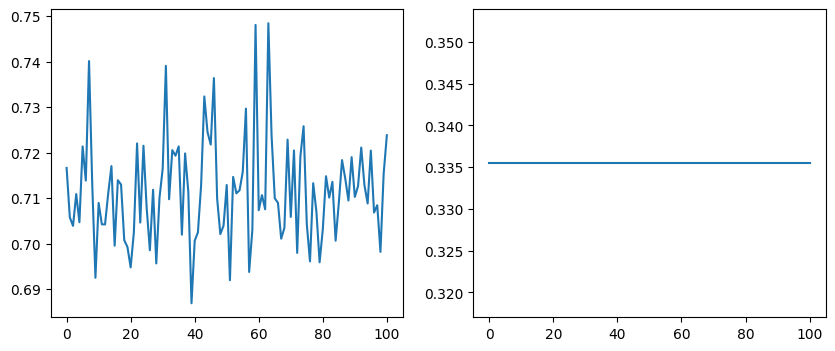

 21%|██        | 105/500 [1:40:02<6:16:20, 57.16s/it]


KeyboardInterrupt: 

In [18]:
train_loop(n_epochs, model, optimizer, train_loader, valid_loader, device, criterion1, criterion2)